# **Bravocado!** ====================================================

<img src="https://www.wellandgood.com/wp-content/uploads/2018/06/Stocksy-Avocado-flat-lay-Marti-Sans.jpg" width="500px"/>

> *Avocados are a naturally nutrient-dense food and contain nearly 20 vitamins and minerals.Also known as an alligator pear or butter fruit, the versatile avocado is the only fruit that provides a substantial amount of healthy monounsaturated fatty acids.*

Many thanks to Justin Kiggins for adding this great dataset. In this notebook I'll take a quick look at some of the features and their correlations and do a bit of machine learning and price forecasting, and for those of you who need convincing that this is important work - take a look at this Google n-gram highlighting the meteoric rise in avocado popularity...

In [1]:
%%html
<iframe name="ngram_chart" 
        src="https://books.google.com/ngrams/interactive_chart?content=avocado&year_start=1800&year_end=2018&corpus=15&smoothing=3&share=&direct_url=t1%3B%2Cavocado%3B%2Cc0" 
        width=900 height=300 marginwidth=0 marginheight=0 hspace=0 vspace=0 frameborder=0 scrolling=no style="float:right">
</iframe>

<center>[https://books.google.com/ngrams/](https://books.google.com/ngrams/graph?content=avocado&case_insensitive=on&year_start=1800&year_end=2008&corpus=15&smoothing=3&share=&direct_url=t4%3B%2Cavocado%3B%2Cc0%3B%2Cs0%3B%3Bavocado%3B%2Cc0%3B%3BAvocado%3B%2Cc0%3B%3BAVOCADO%3B%2Cc0)</center>

### --- ** Let's get started!**

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
sns.set(font_scale = 1.7)

### --- Import and examine the data

In [2]:
# import the csv
df = pd.read_csv('data/avocado.csv')

In [3]:
# examine example data
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [5]:
# examine the entire set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
Unnamed: 0      18249 non-null int64
Date            18249 non-null object
AveragePrice    18249 non-null float64
Total Volume    18249 non-null float64
4046            18249 non-null float64
4225            18249 non-null float64
4770            18249 non-null float64
Total Bags      18249 non-null float64
Small Bags      18249 non-null float64
Large Bags      18249 non-null float64
XLarge Bags     18249 non-null float64
type            18249 non-null object
year            18249 non-null int64
region          18249 non-null object
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


From a first look at the data we can see that there is a mix of data types and header formats, but most importantly we can see that there are no null values - which is good news.

### --- Wrangle the data

In [4]:
# drop unnecessary columns
df = df.drop(['Unnamed: 0'], axis=1)

# clean up the headers
mapping = {"Date": "date", 
           "AveragePrice": "average_price",
           "Total Volume": "total_volume",
           "Total Bags": "total_bags",
           "Small Bags": "small_bags",
           "Large Bags": "large_bags",
           "XLarge Bags": "xlarge_bags"}
df = df.rename(columns=mapping)

# parse the dates
df['date'] = pd.to_datetime(df['date'])

# encode the categorial 'type' and 'region'
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])
df['region_encoded'] = le.fit_transform(df['region'])

Here we have tidied up the data a little, converts to dates from strings to datetimes and added encoding for the categorical variables using *LabelEncoder*

### --- Feature exploration - conventional vs organic

Lets look at the two *types* of avocado in the dataset...

In [7]:
# iterate the types
for typ in df['type'].unique():
    print(typ)

conventional
organic


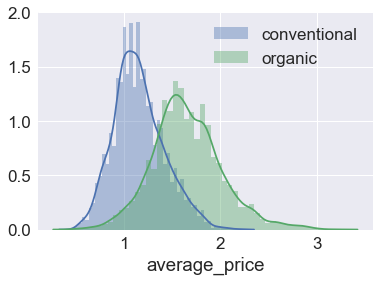

In [8]:
# plot the distribution of price by type
for typ in df['type'].unique():
    sns.distplot( df["average_price"][df['type']==typ], label=typ)
plt.legend()

We can see that there is a clear difference in the average price distribution of convetional and organic avocados, with organic avocados being significantly more expensive. 

In [5]:
# plot the time series of average price
traces = []
for typ in df['type'].unique():
    tmp = df[df['type']==typ]
    tmp = tmp.groupby(['date'], as_index=False)['average_price'].mean()
    traces.append(go.Scatter(x=tmp['date'], y=tmp['average_price'], name=typ))
iplot(traces)

From the above we can see that the average price of organic avocados has been consistently higher than conventional avocados, but also the price of both types of avocado spiked in September 2017, which can easily be explained with a quick google search ... [avocado Prices Climb to an Even Crazier All-time High](http://www.grubstreet.com/2017/09/avocado-prices-climb-to-their-all-time-highest.html)

### --- Feature exploration - regions

Looking at the regions in the dataset...

In [10]:
print(df['region'].unique())
print(len(df['region'].unique()))

['Albany' 'Atlanta' 'BaltimoreWashington' 'Boise' 'Boston'
 'BuffaloRochester' 'California' 'Charlotte' 'Chicago' 'CincinnatiDayton'
 'Columbus' 'DallasFtWorth' 'Denver' 'Detroit' 'GrandRapids' 'GreatLakes'
 'HarrisburgScranton' 'HartfordSpringfield' 'Houston' 'Indianapolis'
 'Jacksonville' 'LasVegas' 'LosAngeles' 'Louisville' 'MiamiFtLauderdale'
 'Midsouth' 'Nashville' 'NewOrleansMobile' 'NewYork' 'Northeast'
 'NorthernNewEngland' 'Orlando' 'Philadelphia' 'PhoenixTucson'
 'Pittsburgh' 'Plains' 'Portland' 'RaleighGreensboro' 'RichmondNorfolk'
 'Roanoke' 'Sacramento' 'SanDiego' 'SanFrancisco' 'Seattle'
 'SouthCarolina' 'SouthCentral' 'Southeast' 'Spokane' 'StLouis' 'Syracuse'
 'Tampa' 'TotalUS' 'West' 'WestTexNewMexico']
54


... we can see 54 distinct regions. Now let's look at the distribution of the average price of avocados as a function of region...

In [11]:
# create a temporary dataset sorted by the average-average_price in each region
tmp = df.copy()
tmp2 = tmp.groupby(['region'], as_index = False)['average_price'].mean()
tmp2 = tmp2.rename(index=str, columns={"average_price": "mean_average_price"})
tmp3 = pd.merge(tmp,tmp2[['region','mean_average_price']], how='left', on='region')
tmp3 = tmp3.sort_values('mean_average_price')

# create a seaborn facet grid plot
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale = 7.0)
pal = sns.cubehelix_palette(len(df['region'].unique()), rot=-.30, light=.7)
g = sns.FacetGrid(tmp3, row="region", hue="region", aspect=30, palette=pal)

g.map(sns.kdeplot, "average_price", clip_on=False, shade=True, alpha=1.0, lw=1.5, bw=.2)
g.map(sns.kdeplot, "average_price", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,ha="left", va="center", transform=ax.transAxes)

g.map(label, "region")
g.fig.subplots_adjust(hspace=-.25)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.show()

### --- Feature exploration - the numeric variables

In [11]:
# create a temporary data frame with only the numeric fields for exploration
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
tmp = df.select_dtypes(include=numerics)
tmp = tmp.drop(['year', 'region_encoded', 'type_encoded'], axis=1)

Lets examine the relationship between the numeric features isolated in the temporary data frame

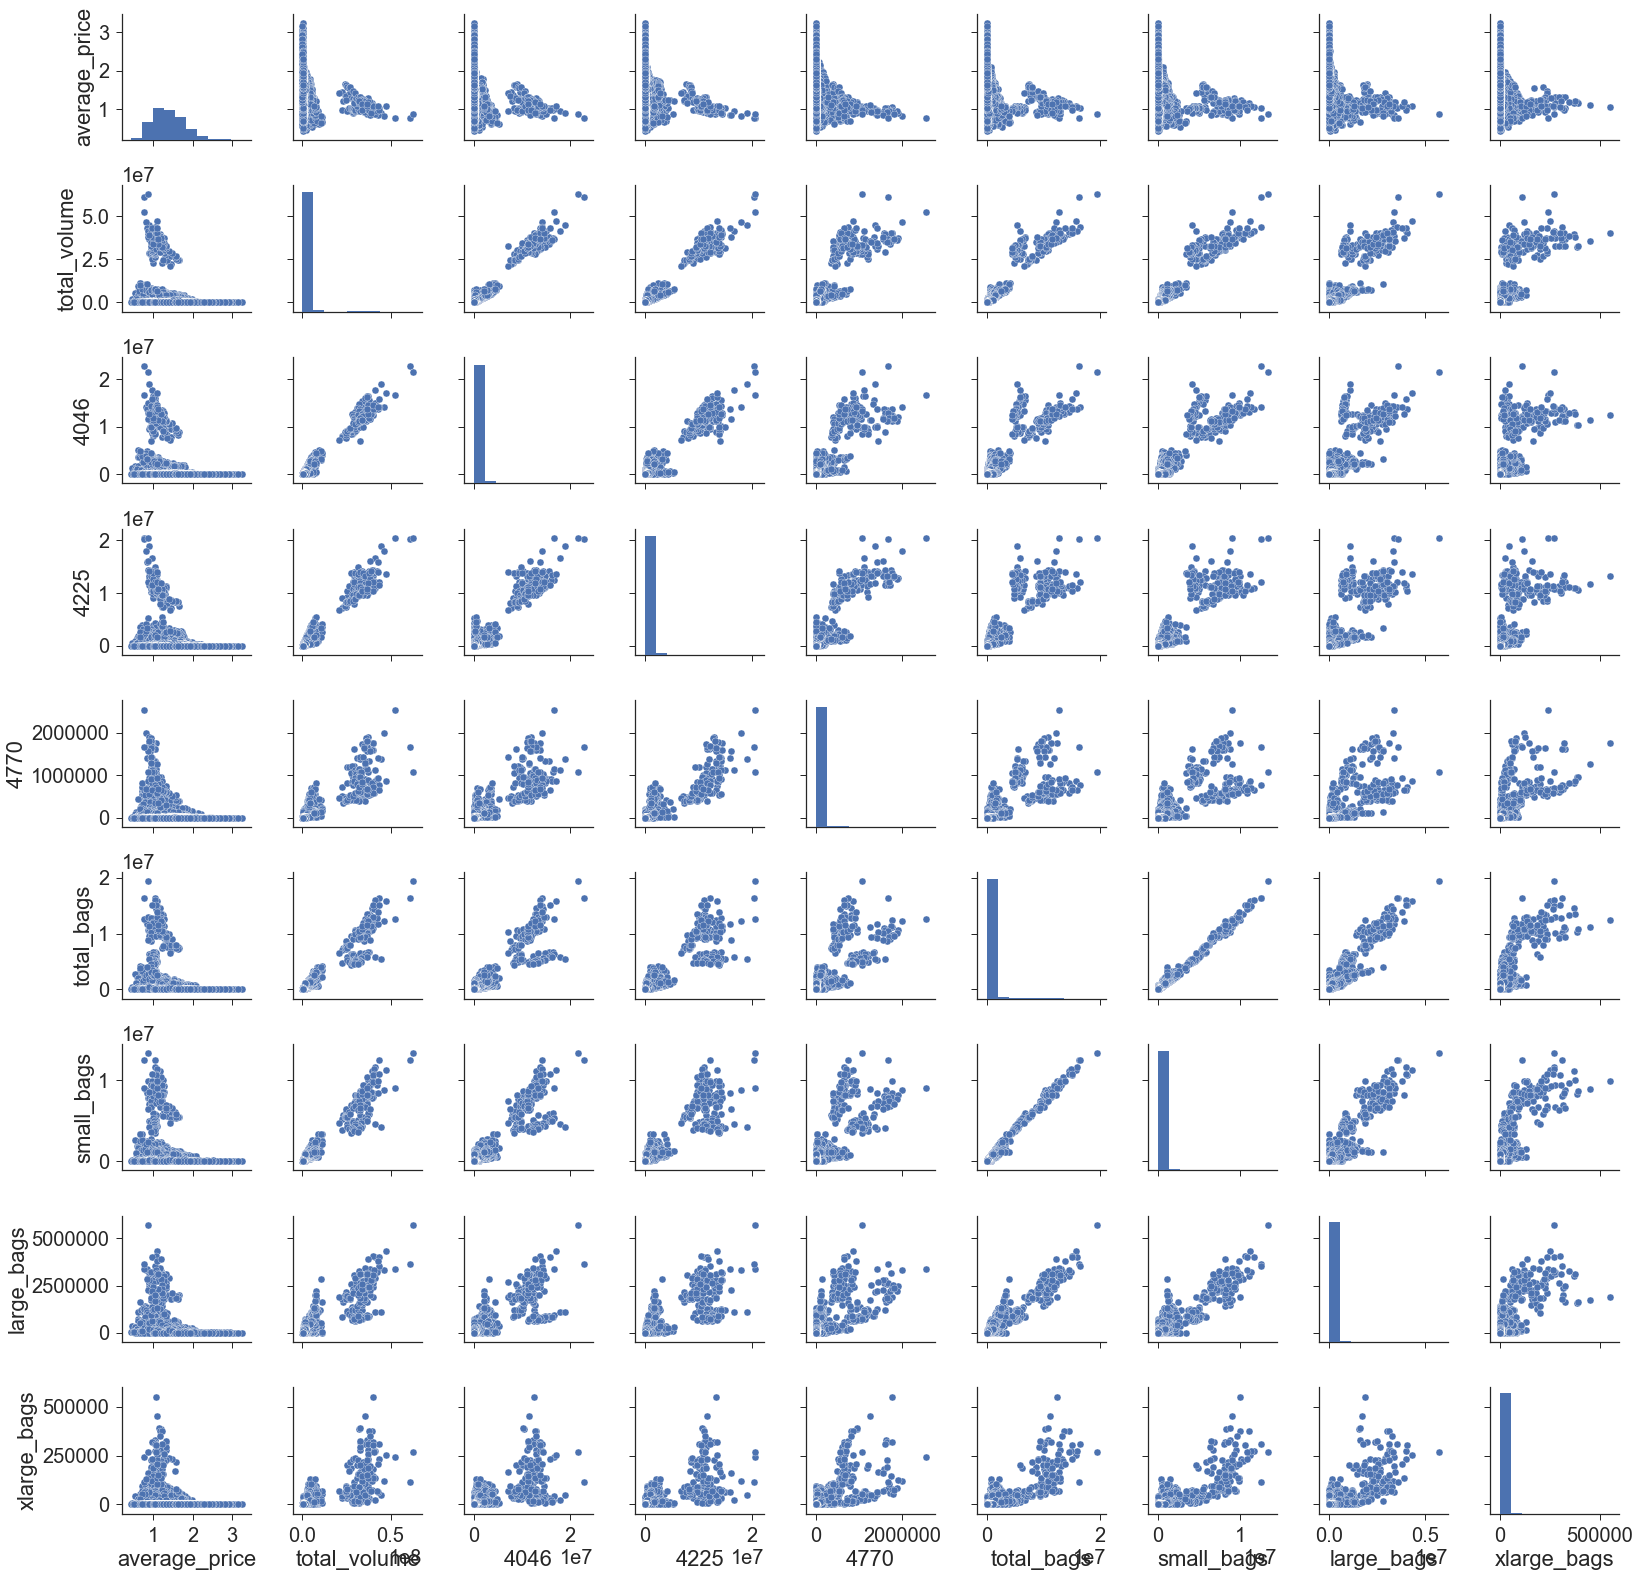

In [13]:
# pair plot the relationship between numeric features
sns.set(style="ticks", font_scale = 2.0, color_codes=True)
sns.pairplot(tmp)

Using a *Seaborn - pair plot* we can clearly see a lot of correlation between many of the variables, we can summarise this using a heat map of the correlation coefficients between the same variables

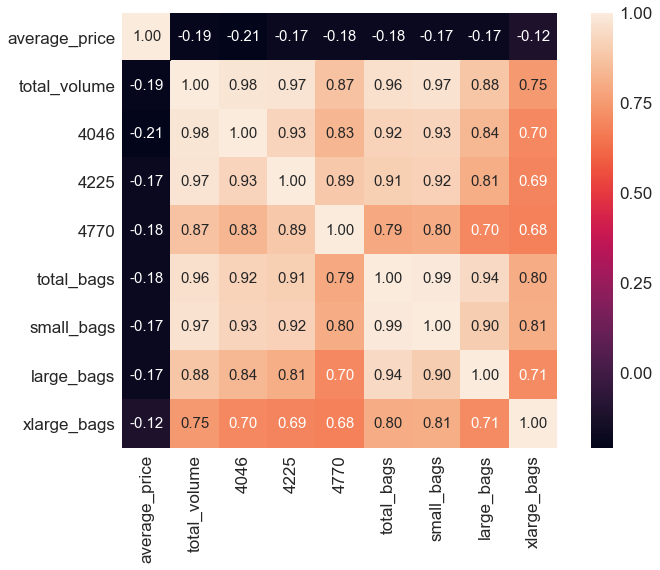

In [15]:
# heat map of the correlation coefficients between numeric features
rcParams['figure.figsize'] = 12, 8
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale = 1.7)
cm = np.corrcoef(tmp.values.T)
hm = sns.heatmap(cm, cbar = True, annot = True,square = True, fmt = '.2f',
                 annot_kws = {'size':15}, yticklabels = list(tmp), xticklabels = list(tmp))

The heatmap shows that the average price of the avocados is not strongly correlated to any of the other numeric features, but that those other numeric features are all strongly correlated to each other. 

### --- Machine learning - classifying avocado type

Given that the type of avocoda is such a distinguishing feature we should be able to use machine learning to build a strong classifier of avocado type

In [10]:
# binarize the categorical 'region'
lb = LabelBinarizer()
trns = lb.fit_transform(df['region'].values)
tmp = pd.DataFrame(trns, columns = ["region_"+str(int(i)) for i in range(trns.shape[1])])
df = pd.concat([df, tmp], axis=1)

# choose features to train against
x = df.drop(['type', 'type_encoded', 'region', 'region_encoded', 'date'], axis = 1)
print( "Using features: ", list(x))

# choose output variable
y = df['type_encoded']

# get test and train sets
x_train,x_test,y_train,y_test = train_test_split(x, y, random_state = 0)

# train 3 different classifier models
lr =  LogisticRegression(penalty='l1', tol=0.0001).fit(x_train, y_train)
sv = SVC(gamma='auto').fit(x_train, y_train) 
rf =  RandomForestClassifier(n_estimators = 100, random_state = 0, max_features = 2).fit(x_train, y_train)

# print the model accuracies
print("a logistic regression classifier gives a test data score of {:.4f}".format(lr.score(x_test,y_test)))
print("a support vector classifier give a test data score of {:.4f}".format(sv.score(x_test,y_test)))
print("a random forest classifier gives a test data score of {:.4f}".format(rf.score(x_test,y_test)))

Using features:  ['average_price', 'total_volume', '4046', '4225', '4770', 'total_bags', 'small_bags', 'large_bags', 'xlarge_bags', 'year', 'region_0', 'region_1', 'region_2', 'region_3', 'region_4', 'region_5', 'region_6', 'region_7', 'region_8', 'region_9', 'region_10', 'region_11', 'region_12', 'region_13', 'region_14', 'region_15', 'region_16', 'region_17', 'region_18', 'region_19', 'region_20', 'region_21', 'region_22', 'region_23', 'region_24', 'region_25', 'region_26', 'region_27', 'region_28', 'region_29', 'region_30', 'region_31', 'region_32', 'region_33', 'region_34', 'region_35', 'region_36', 'region_37', 'region_38', 'region_39', 'region_40', 'region_41', 'region_42', 'region_43', 'region_44', 'region_45', 'region_46', 'region_47', 'region_48', 'region_49', 'region_50', 'region_51', 'region_52', 'region_53', 'region_0', 'region_1', 'region_2', 'region_3', 'region_4', 'region_5', 'region_6', 'region_7', 'region_8', 'region_9', 'region_10', 'region_11', 'region_12', 'region_1

What a great result on the first try, in particular for the random forest model. However the support vector classifier is clearly having some trouble reaching the same lofty heights at the other models. Let's see if we can use dimensionality reduction to improve the support vector model.

In [8]:
# print starting dimensionality
print(x_train.shape)

# use PCA to reduce the dimensionality
pca = PCA(n_components=5, whiten=True) ## quite a drastic number I guess but lets see if that works! also, removes linear correlation
X_train_scaled_reduced = pca.fit_transform(x_train)
X_test_scaled_reduced = pca.fit_transform(x_test)

# print resulting dimensionality
print(X_train_scaled_reduced.shape)

# print the explained variance
print(pca.explained_variance_ratio_.cumsum())

(13686, 172)
(13686, 5)
[0.9864158  0.9936865  0.99919526 0.99977745 0.99999143]


Printing the cumulative sum of the explained variance we can see that in reducing from 64 to 5 dimensions we can still explain 99.99% of the variance in the data. Lets see how fitting against the 5 dimensions does...

In [9]:
# re-train the 3 different classifier models
lr =  LogisticRegression(penalty='l1', tol=0.0001).fit(X_train_scaled_reduced, y_train)
sv = SVC(gamma='auto',  kernel='linear', tol=0.001).fit(X_train_scaled_reduced, y_train) 
rf =  RandomForestClassifier(n_estimators = 100, random_state = 0, max_features = 2).fit(X_train_scaled_reduced, y_train)

# print the model accuracies
print("a logistic regression classifier gives a test data score of {:.4f}".format(lr.score(X_test_scaled_reduced,y_test)))
print("a support vector classifier give a test data score of {:.4f}".format(sv.score(X_test_scaled_reduced,y_test)))
print("a random forest classifier gives a test data score of {:.4f}".format(rf.score(X_test_scaled_reduced,y_test)))

a logistic regression classifier gives a test data score of 0.8904
a support vector classifier give a test data score of 0.8762
a random forest classifier gives a test data score of 0.9020


Clearly the reduced dimensionality has degraded the logistic regression and random forest models (though they still perform remarkably well off so few dimensions) but the support vector classifier has improved enormously thanks to the dimensionality reductions

# ====================================================

<img src="http://newsletter.deltaphilambda.org/wp-content/uploads/2016/07/avocado-carrot-768x506.png" width="750px"/>